In [1]:
###-----------------------------------------------------------------------------
## Imports
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import math
from tensorforce.environments import Environment
from tensorforce.agents import Agent

# Set up environment

Want to set up environment that can call out to a rules system and check for bad actions, return a reward but do not advance the state, let them retry.

In [87]:
###-----------------------------------------------------------------------------
### Environment definition
class ThermostatEnvironment(Environment):
    def __init__(self):
        super().__init__()

        ## Some initializations.  Will eventually parameterize this in the constructor.
        self.tau = 3.0 # Time decay constant
        self.timestep = 0 # Local tracking of timestep

        ## Managing switching on from off.
        ## Set an interval in which we can do a maximum number of switchons from off
        self.switchon_period = 10 
        self.switchon_max = 3.0
        ## Keep track of last state
        self.switchon_laststate = 0
        ## Keep record of when we switched off to on
        self.switchon_record = []
        
        ## State depends on how we define state.
        ## Here, state is just the current temp
        self.state = np.append(np.random.random(size=(1,)),np.array([self.switchon_max]))


    def reset(self):
        """Reset state.
        """
        self.switchon_record = []        
        self.state = np.append(np.random.random(size=(1,)),np.array([self.switchon_max]))
        return self.state


    # Optional, should only be defined if environment has a natural maximum
    # episode length
    def max_episode_timesteps(self):
        return super().max_episode_timesteps()


    # Optional
#     def close(self):
#         super().close()


    def states(self):
        return dict(type='float', shape=(2,))


    def actions(self):
        """Action 0 means no heater, temperature approaches 0.0.  Action 1 means
        the heater is on and the room temperature approaches 1.0.
        """
        return dict(type='int', num_values=2)


#     def response(self, action):
#         """Respond to an action.  When the action is 1, the temperature
#         exponentially decays approaches 1.0.  When the action is 0,
#         the current temperature decays towards 0.0.
#         """
#         new_temp = action + (self.state[0] - action) * math.exp(-1.0 / self.tau)
#         return np.array([new_temp,
#                          self.state[1]])


    def reward_compute(self):
        """ The reward here is 1.0 if the current temp is between 0.4 and 0.6,
        else it drops off linearly as you move away from the [0.4, 0.6] boundary.
        
        Return the value within the numpy array, not the numpy array.
        """
        delta = abs(self.state[0] - 0.5)
        if delta < 0.1:
            return 0.0
        else:
            return -delta + 0.1


    def execute(self, actions):
        ## Update timestep
        self.timestep += 1
        
        
        ## =====================================
        ## HERE WE INSTRUMENT CALL TO RULES
        ## =====================================

        
        ###--------------------------------------
        ## Compute update to available actions
        ## Update off_to_ons if necessary
        if actions == 1 and self.switchon_laststate == 0:
            self.switchon_record += [self.timestep]

        ## Update last state to current state
        self.switchon_laststate = actions


        ###--------------------------------------
        ## First slot of state, which is the updated temperature
        # self.state = self.response(actions)
        self.state[0] = actions + (self.state[0] - actions) * math.exp(-1.0 / self.tau)

        
        ###--------------------------------------
        ## Update 2nd slot of state, which is remaining startups
        ## Make a list of the events within the window
        lstWindowEvents = [e for e in self.switchon_record
                              if self.timestep - e <= self.switchon_period]
        
        self.state[1] = self.switchon_max - np.float(len(lstWindowEvents))

        ###--------------------------------------
        ## Check conditions for return
        ## If we have done too many startups, end episode, return penalty
        ## Commenting this out means that this environment has no constraint on startups
#         if int(self.state[1]) < 0:
#             return self.state, True, -10.0

        ## Compute the reward
        reward = self.reward_compute()

        ## Return tuple of (state, terminal, reward)
        return self.state, False, reward


###-----------------------------------------------------------------------------
### Create the environment
###   - Tell it the environment class
###   - Set the max timestamps that can happen per episode
environment = environment = Environment.create(
    environment=ThermostatEnvironment,
    max_episode_timesteps=100)


environment.reset()
environment.execute(1)

(array([0.29403532, 2.        ]), 0, -0.10596467774146065)

In [77]:
# environment.environment.__dict__
vars(environment.environment)

{'_max_episode_timesteps': 100,
 '_expect_receive': None,
 '_actions': None,
 'tau': 3.0,
 'timestep': 1,
 'switchon_period': 10,
 'switchon_max': 3.0,
 'switchon_laststate': 1,
 'switchon_record': [1],
 'state': array([0.89325552, 2.        ])}

# Agent setup

Here we configure a type of agent to learn against this environment.  There are many agent configurations to choose from, which we will not cover here.  We will not discuss what type of agent to choose here -- we will just take a basic agent to train.

In [88]:
agent = Agent.create(
    agent='tensorforce', environment=environment, update=64,
    objective='policy_gradient', reward_estimation=dict(horizon=10)
)

INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


# Check: Untrained Agent Performance

Let's see how the untrained agent performs on the environment.  The red horizontal lines are the target bands for the temperature.

The agent doesn't take actions to try and get the temperature within the bands.  It either initializes a policy to the heater always off or always on.

In [79]:
### Initialize
environment.reset()
vars(environment.environment)

{'_max_episode_timesteps': 100,
 '_expect_receive': None,
 '_actions': None,
 'tau': 3.0,
 'timestep': 1,
 'switchon_period': 10,
 'switchon_max': 3.0,
 'switchon_laststate': 1,
 'switchon_record': [],
 'state': array([0.97278685, 3.        ])}

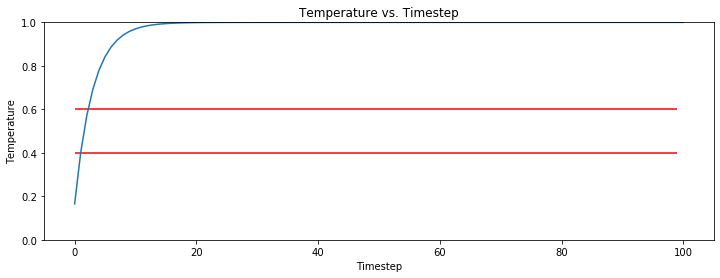

In [89]:
## Creation of the environment via Environment.create() creates
## a wrapper class around the original Environment defined here.
## That wrapper mainly keeps track of the number of timesteps.
## In order to alter the attributes of your instance of the original
## class, like to set the initial temp to a custom value, like here,
## you need to access the `environment` member of this wrapped class.
## That is why you see the way to set the current_temp like below.
# environment.environment.current_temp = np.array([0.5])
# states = environment.environment.current_temp
environment.reset()

internals = agent.initial_internals()
terminal = False

### Run an episode
temp = [environment.environment.state[0]]
while not terminal:
    actions, internals = agent.act(states=environment.environment.state, internals=internals, evaluation=True)
    states, terminal, reward = environment.execute(actions=actions)
    temp += [states[0]]
    
### Plot the run
plt.figure(figsize=(12, 4))
ax=plt.subplot()
ax.set_ylim([0.0, 1.0])
plt.plot(range(len(temp)), temp)
plt.hlines(y=0.4, xmin=0, xmax=99, color='r')
plt.hlines(y=0.6, xmin=0, xmax=99, color='r')
plt.xlabel('Timestep')
plt.ylabel('Temperature')
plt.title('Temperature vs. Timestep')
plt.show()

In [84]:
vars(environment.environment)

{'_max_episode_timesteps': 100,
 '_expect_receive': None,
 '_actions': None,
 'tau': 3.0,
 'timestep': 301,
 'switchon_period': 10,
 'switchon_max': 3.0,
 'switchon_laststate': 1,
 'switchon_record': [],
 'state': array([1., 3.])}

# Train the agent

Here we train the agent against episodes of interacting with the environment.

In [94]:
# Train for 1200 episodes
for _ in range(1200):
    states = environment.reset()
    terminal = False
    while not terminal:
        actions = agent.act(states=states)
        states, terminal, reward = environment.execute(actions=actions)
        agent.observe(terminal=terminal, reward=reward)

# Check: Trained Agent Performance

You can plainly see that this is toggling the heater on/off to keep the temperature within the target band!

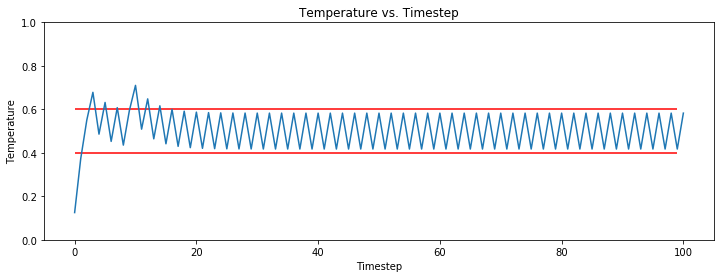

In [96]:
### Initialize
environment.reset()

## Creation of the environment via Environment.create() creates
## a wrapper class around the original Environment defined here.
## That wrapper mainly keeps track of the number of timesteps.
## In order to alter the attributes of your instance of the original
## class, like to set the initial temp to a custom value, like here,
## you need to access the `environment` member of this wrapped class.
## That is why you see the way to set the current_temp like below.
# environment.environment.current_temp = np.array([1.0])
# states = environment.environment.current_temp

internals = agent.initial_internals()
terminal = False

### Run an episode
temp = [environment.environment.state[0]]
while not terminal:
    actions, internals = agent.act(states=environment.environment.state, internals=internals, evaluation=True)
    states, terminal, reward = environment.execute(actions=actions)
    temp += [states[0]]

### Plot the run
plt.figure(figsize=(12, 4))
ax=plt.subplot()
ax.set_ylim([0.0, 1.0])
plt.plot(range(len(temp)), temp)
plt.hlines(y=0.4, xmin=0, xmax=99, color='r')
plt.hlines(y=0.6, xmin=0, xmax=99, color='r')
plt.xlabel('Timestep')
plt.ylabel('Temperature')
plt.title('Temperature vs. Timestep')
plt.show()